## Compute lattice constant using the current potential.

In [1]:
from ase.build import bulk
#from ase.db import connect
from ase.eos import calculate_eos
input = {}
with open('Input.txt', 'r') as file:
    for line in file:
        # Ignore lines starting with '#'
        if line.startswith('#'):
            continue
        key, value = line.strip().split(' : ')
        try:
            # Convert to integer if possible
            input[key] = int(value)
        except ValueError:
            # If not possible, store as string
            input[key] = value

atoms = bulk(input['surface_atom'], input['lattice'])
if (input['calc_method'] == 'EMT'):
    from ase.calculators.emt import EMT
    atoms.calc = EMT()
elif (input['calc_method'] == 'LJ'):
    from ase.calculators.lj import LennardJones
    atoms.calc = LennardJones()
elif (input['calc_method'] == 'EAM'):
    from ase.calculators.eam import EAM
    atoms.calc = EAM()

eos = calculate_eos(atoms) #For now eos only seems to work with EMT, not LJ or EAM
v, e, B = eos.fit()  # find minimum
# Do one more calculation at the minimum and write to database:
atoms.cell *= (v / atoms.get_volume())**(1 / 3)
atoms.get_potential_energy()

-0.007036492048371201

## Adsorb one C atom using built-in BFGS.

### First prepare the supercell (so the atom adsorbate does not see its mirror image).

In [2]:
# Now prepare adsorption.
from ase.build import add_adsorbate, fcc111
from ase.visualize import view
ads = input['adsorbant_atom']
n_layers = input['number_of_layers']
a = atoms.cell[0, 1] * 2 # Equilibrium lattice constant.
atoms = fcc111(input['surface_atom'], (input['supercell_x_rep'], input['supercell_y_rep'], n_layers), a=a)
atoms.get_tags()

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [3]:
#view(atoms, viewer='x3d')
#atoms
#atoms.get_positions()

## Add single atom adsorbate.

In [4]:
ads_height = float(input['adsorbant_init_h']) #modified initial conditions
add_adsorbate(atoms, ads, height=ads_height, position=input['ads_init_pos'])
#defined vacuum layer for no overlap between supercells NEEDS CONVERGENCE STUDY
atoms.center(vacuum = input['supercell_vacuum'], axis = 2) 
atoms.get_tags()
atoms.get_positions()

array([[1.26919466e+00, 7.32769880e-01, 1.00000000e+01],
       [3.80758399e+00, 7.32769880e-01, 1.00000000e+01],
       [6.34597331e+00, 7.32769880e-01, 1.00000000e+01],
       [8.88436264e+00, 7.32769880e-01, 1.00000000e+01],
       [2.53838933e+00, 2.93107952e+00, 1.00000000e+01],
       [5.07677865e+00, 2.93107952e+00, 1.00000000e+01],
       [7.61516798e+00, 2.93107952e+00, 1.00000000e+01],
       [1.01535573e+01, 2.93107952e+00, 1.00000000e+01],
       [3.80758399e+00, 5.12938916e+00, 1.00000000e+01],
       [6.34597331e+00, 5.12938916e+00, 1.00000000e+01],
       [8.88436264e+00, 5.12938916e+00, 1.00000000e+01],
       [1.14227520e+01, 5.12938916e+00, 1.00000000e+01],
       [5.07677865e+00, 7.32769880e+00, 1.00000000e+01],
       [7.61516798e+00, 7.32769880e+00, 1.00000000e+01],
       [1.01535573e+01, 7.32769880e+00, 1.00000000e+01],
       [1.26919466e+01, 7.32769880e+00, 1.00000000e+01],
       [2.70452304e-17, 1.46553976e+00, 1.20725862e+01],
       [2.53838933e+00, 1.46553

In [5]:
#view(atoms, viewer='x3d')
#atoms[-1]

In [6]:
# Constrain all atoms except the adsorbate:
from ase.constraints import FixAtoms
fixed = list(range(len(atoms) - 1))
atoms.constraints = [FixAtoms(indices=fixed)]

## Optimize adsorbate position usgin built-in BFGS from ASE.

File 'BFGS.log' has been deleted.


c:\Users\arnau\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\visualize\plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=42.
  animation = FuncAnimation(fig, drawimage, frames=images,
MovieWriter ffmpeg unavailable; using Pillow instead.


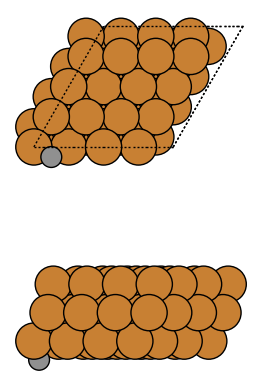

In [7]:
from ase.optimize import BFGS
import time
import os
from ase.io.trajectory import Trajectory
import ase.io

file_path = 'BFGS.log'
## Check if the file exists
if os.path.exists(file_path):
    # Delete the file
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"File '{file_path}' does not exist.")


atoms.calc = EMT()
opt = BFGS(atoms, logfile='BFGS.log', trajectory='BFGS.traj')
BFGS_start = time.time()
opt.run(fmax=0.0001)
BFGS_runtime = time.time() - BFGS_start

BFGS_traj = Trajectory('BFGS.traj')

bfgs_list = list(Trajectory('BFGS.traj'))
rot_bfgs_list = list(Trajectory('BFGS.traj'))
for atoms_rot in rot_bfgs_list:
    atoms_rot.rotate(90, 'x')
    atoms_rot.rotate(45, 'y') 

bfgs_combined_atoms_list = []
for atoms_bfgs, atoms_rot in zip(bfgs_list, rot_bfgs_list):
    # Translate atoms_test to avoid overlap
    atoms_rot.translate([0, 0, 0])  # Adjust the translation vector as needed
    bfgs_combined_atoms_list.append(atoms_bfgs + atoms_rot)


ase.io.write('BFGS_traj.gif', bfgs_combined_atoms_list, interval=100)

In [8]:
#Store BFGS.log as dataframes
import pandas as pd
df_bfgs = pd.read_csv('BFGS.log', skiprows=0, delim_whitespace=True)
# change df_bfgs['Time'] from str to runtime from first run in seconds
df_bfgs['Time'] = pd.to_datetime(df_bfgs['Time'])
df_bfgs['Time'] = df_bfgs['Time'].dt.strftime('%H:%M:%S')
df_bfgs['Time'] = pd.to_timedelta(df_bfgs['Time'])
df_bfgs['Time'] = df_bfgs['Time'].dt.total_seconds()
df_bfgs['Time'] = df_bfgs['Time'] - df_bfgs['Time'][0]

C:\Users\arnau\AppData\Local\Temp\ipykernel_7592\1877868681.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_bfgs = pd.read_csv('BFGS.log', skiprows=0, delim_whitespace=True)
C:\Users\arnau\AppData\Local\Temp\ipykernel_7592\1877868681.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_bfgs['Time'] = pd.to_datetime(df_bfgs['Time'])
C:\Users\arnau\AppData\Local\Temp\ipykernel_7592\1877868681.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_bfgs['Time'] = df_bfgs['Time'] - df_bfgs['Time'][0]


In [9]:
# Final adsorbate position.
### print(atoms[3].position)
print(atoms[-1].position) # modified to get adsorbate position
BFGS_params = atoms[-1].position.copy()
# Final energy.
bfgs_en = atoms.get_potential_energy()
print(atoms.get_potential_energy())

[ 1.26919466 -0.73278468 15.5052035 ]
11.224673078766847


## Comparison with BoTorch

In [10]:
import numpy as np
#import torch

In [11]:
# Do not allow our atom to go inside the surface. 
# Also restrict x-y to the unit cell size.
bulk_z_max = np.max(atoms[:-1].positions[:, 2]) #modified to account for changes in initial conditions + universal
print(bulk_z_max)
cell_x_min, cell_x_max = float(np.min(atoms.cell[:, 0])), float(np.max(atoms.cell[:, 0]))
cell_y_min, cell_y_max = float(np.min(atoms.cell[:, 1])), float(np.max(atoms.cell[:, 1]))
#z_adsorb_max = 3 * ads_height
z_adsorb_max = atoms[-1].position[-1] + 5 # modified to account for changes in initial conditions

14.145172411082656


## Call functions from separate file instead of defining in notebook

In [12]:
import pickle
with open('atoms.pkl', 'wb') as f:
    pickle.dump(atoms, f)

#import Note_func

## Set up the optimization experiment in Ax.

In [13]:
from ax.service.ax_client import AxClient
from Note_func import gs
from ax.service.utils.instantiation import ObjectiveProperties

from ax.global_stopping.strategies.improvement import ImprovementGlobalStoppingStrategy
from ax.exceptions.core import OptimizationShouldStop
# Start considering stopping only after the 5 initialization trials + 5 real trials.
# Stop if the improvement in the best point in the past 5 trials is less than
# 1% of the IQR thus far.
stopping_strategy = ImprovementGlobalStoppingStrategy(
    min_trials=5 + 5, window_size=5, improvement_bar=0.01
)

# Initialize the client - AxClient offers a convenient API to control the experiment
if input['opt_stop'] == 'T':
    ax_client = AxClient(generation_strategy=gs, global_stopping_strategy=stopping_strategy)
elif input['opt_stop'] == 'F':
    ax_client = AxClient(generation_strategy=gs)

ax_client.create_experiment(
    name="adsorption_experiment",
    parameters=[
        {
            "name": "x",
            "type": "range",
            "bounds": [float(cell_x_min), float(cell_x_max)],
        },
        {
            "name": "y",
            "type": "range",
            "bounds": [float(cell_y_min), float(cell_y_max)],
        },
        {
            "name": "z",
            "type": "range",
            "bounds": [float(bulk_z_max), float(z_adsorb_max)], #I made a modification here, switched both bounds.
        },
    ],
    objectives={"adsorption_energy": ObjectiveProperties(minimize=True)},
    # parameter_constraints=["x1 + x2 <= 2.0"],  # Optional.
    # outcome_constraints=["l2norm <= 1.25"],  # Optional.
)

[INFO 03-25 16:07:48] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 03-25 16:07:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-25 16:07:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter y. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-25 16:07:48] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter z. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-25 16:07:48] ax.service.uti

## Run the BO loop.

In [14]:
from Note_func import evaluate
import time
# Run the optimization loop. This is where the magic happens. 
start = time.time()
run_time = []
N_BO_steps = input['n_bo_steps']

BO_trace_space_log_x = []
BO_trace_space_log_y = []
BO_trace_space_log_z = []

if input['opt_stop'] == 'T':
    #run this if we want to stop the optimization after a threshold
    for i in range(N_BO_steps):
        try: 
            parameters, trial_index = ax_client.get_next_trial()
        except OptimizationShouldStop as exc:
            print(exc.message)
            break
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))
        run_time.append(time.time() - start)
        #Store current BO trajectory
        params = ax_client.get_best_parameters()[:1][0]
        BO_trace_space_log_x.append(params['x'])
        BO_trace_space_log_y.append(params['y'])
        BO_trace_space_log_z.append(params['z'])
        
elif input['opt_stop'] == 'F':
    #run this if we want to run the optimization for a fixed number of steps
    for i in range(N_BO_steps):
        parameters, trial_index = ax_client.get_next_trial()
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))
        run_time.append(time.time() - start)
        #Store current BO trajectory
        params = ax_client.get_best_parameters()[:1][0]
        BO_trace_space_log_x.append(params['x'])
        BO_trace_space_log_y.append(params['y'])
        BO_trace_space_log_z.append(params['z'])

[INFO 03-25 16:07:50] ax.service.ax_client: Generated new trial 0 with parameters {'x': 0.299627, 'y': 7.224772, 'z': 15.994288} using model Sobol.
c:\Users\arnau\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',
[INFO 03-25 16:07:50] ax.service.ax_client: Completed trial 0 with data: {'adsorption_energy': (11.783716, 0.0)}.
[INFO 03-25 16:07:50] ax.service.ax_client: Generated new trial 1 with parameters {'x': 7.423219, 'y': 7.233618, 'z': 15.812302} using model Sobol.
c:\Users\arnau\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',
[INFO 03-25 16:07:50] ax.service.ax_client: Completed trial 1 with data: {'adsorption_energy': (11.479383, 0.0)}.
[INFO 03-25 16:07:50] ax.service.ax_cl

## (Optionnal : Load previous experiment result from JSON file)

In [ ]:
if 'ax_client' not in globals() or ax_client is None:
    ax_client = AxClient.load_from_json_file(filepath='test_json.json')

#report = ax_client.get_report()
#ax_client.get_best_trial()

## Save results in csv

In [15]:
import glob

#Build result dataframe
df = ax_client.get_trials_data_frame()
df['bo_trace'] = ax_client.get_trace()
df["run_time"] = run_time
df["BFGS_runtime"] = BFGS_runtime
params = ax_client.get_best_parameters()[:1][0]
df['opt_bfgs_x']= BFGS_params[0]
df['opt_bfgs_y']= BFGS_params[1]
df['opt_bfgs_z']= BFGS_params[2]

df['opt_bo_x']= params['x']
df['opt_bo_y']= params['y']
df['opt_bo_z']= params['z']

df['opt_bo_energy'] = ax_client.get_best_parameters()[1][0]['adsorption_energy']
df['opt_bfgs_energy'] = bfgs_en


#Define the file name format
file_name_format = f"ase_ads_DF_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_*.csv"
num_files = len(glob.glob(file_name_format))
curr_date_time = time.strftime("%Y-%m-%d_%H-%M-%S")

#Save results as dataframe csv file
dfname = f"ase_ads_DF_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_{curr_date_time}_{num_files}.csv"

#Save BO trajectory as dataframe csv file
df_bo_space_trace = pd.DataFrame(list(zip(BO_trace_space_log_x, BO_trace_space_log_y, BO_trace_space_log_z)), columns =['x', 'y', 'z'])

df_bo_space_trace_name = f"ase_ads_DF_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_BO_space_trace_{curr_date_time}_{num_files}.csv"

if input["save_fig"] == "T":
    df.to_csv(dfname, index=False)
    df_bo_space_trace.to_csv(df_bo_space_trace_name, index=False)

[WARNING 03-25 16:09:09] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


In [16]:
df_bo_space_trace

,x,y,z
0,0.299627,7.224772,15.994288
1,7.423219,7.233618,15.812302
2,7.423219,7.233618,15.812302
3,7.423219,7.233618,15.812302
4,7.423219,7.233618,15.812302
5,7.423219,7.233618,15.812302
6,7.423219,7.233618,15.812302
7,7.423219,7.233618,15.812302
8,7.423219,7.233618,15.812302
9,7.423219,7.233618,15.812302


## Display Results

## Plot BO space trajectory trace

c:\Users\arnau\AppData\Local\Programs\Python\Python310\lib\site-packages\ase\visualize\plot.py:59: UserWarning: You passed in an explicit save_count=100 which is being ignored in favor of len(frames)=40.
  animation = FuncAnimation(fig, drawimage, frames=images,
MovieWriter ffmpeg unavailable; using Pillow instead.


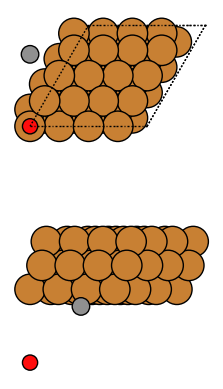

In [23]:
# Plot the BO trajectory 
from ase.io.trajectory import Trajectory
import ase.io
from ase import Atoms

atoms_copy = atoms.copy()
traj = Trajectory('BO.traj', 'w', atoms)
traj_rot = Trajectory('BO_rot.traj', 'w', atoms_copy)
traj_trial = Trajectory('trial_atom.traj', 'w')
traj_trial_rot = Trajectory('trial_atom_rot.traj', 'w')
#Transform df_bo_space_trace to ASE trajectory
for i in range(len(df_bo_space_trace)):
    atoms[-1].position[:] = df_bo_space_trace['x'][i],df_bo_space_trace['y'][i],df_bo_space_trace['z'][i]
    traj.write(atoms)
    atoms_copy = atoms.copy()
    atoms_copy.translate([0, 0, 0])
    atoms_copy.rotate(90, 'x')
    atoms_copy.rotate(45, 'y')
    traj_rot.write(atoms_copy)
    trial_atom = Atoms('O', positions=[[df['x'][i], df['y'][i], df['z'][i]]])
    trial_atom.set_cell(atoms.get_cell())
    trial_atom.set_pbc(atoms.get_pbc())
    traj_trial.write(trial_atom)
    trial_copy = trial_atom.copy()
    trial_copy.rotate(90, 'x')
    trial_copy.rotate(45, 'y')
    traj_trial_rot.write(trial_copy)

BO_atoms_list = list(Trajectory('BO.traj'))
BO_atoms_list_rot = list(Trajectory('BO_rot.traj'))
traj_trial_list = list(Trajectory('trial_atom.traj'))
traj_trial_list_rot = list(Trajectory('trial_atom_rot.traj'))

combined_atoms_list = []
for atoms, atoms_rot, trial_a, trial_a_rot in zip(BO_atoms_list, BO_atoms_list_rot, traj_trial_list, traj_trial_list_rot):
    # Translate atoms_test to avoid overlap
    atoms_rot.translate([0, 0, 0])  # Adjust the translation vector as needed
    combined_atoms_list.append(atoms + atoms_rot + trial_a + trial_a_rot)

if input["save_fig"] == "T":
    ase.io.write('BO_space_trace.gif', combined_atoms_list, interval=400)


## Plot Evolution of adsorption energy.

In [ ]:
from ax.utils.notebook.plotting import render
# from botorch.acquisition
#render(ax_client.get_optimization_trace(objective_optimum=0.0)) #objective optimum should be the bare surface without additionnal atom

#Build Optimization trace plot from scratch
import matplotlib.pyplot as plt

# Plot the optimization trace vs steps
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].set_title('BO Optimized Adsorption vs steps')
ax[0].set_xlabel("Optimization step")
ax[0].set_ylabel("Current optimum")
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].grid(True, linestyle='--', color='0.7', zorder=-1, linewidth=1, alpha=0.5)
# Add horizontal line at x = gs_init_steps to indicate the end of the initialization trials.
ax[0].axvline(x=input['gs_init_steps'], color='k', linestyle='--', linewidth=2, alpha=0.5, label='End of initialization trials')

#bfgs
x_bfgs = range(len(df_bfgs))
y_bfgs = df_bfgs['Energy']
ax[0].plot(x_bfgs, y_bfgs, label=f"{input['calc_method']}_BFGS", color='r', marker='o', linestyle='-')

#BO
trace = df['bo_trace']
x = range(len(trace))
ax[0].plot(x, trace, label=f"{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}", color='b', marker='o', linestyle='-')

# Plot the optimization trace vs time
ax[1].set_title('BO Optimized Adsorption vs time')
ax[1].set_xlabel("Optimization time (s)")
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].grid(True, linestyle='--', color='0.7', zorder=-1, linewidth=1, alpha=0.5)
#BFGS
xt_bfgs = df_bfgs['Time']
ax[1].plot(xt_bfgs, y_bfgs, label=f"{input['calc_method']}_BFGS", color='r', marker='o', linestyle='-')
#BO
xt_BO = df['run_time']
ax[1].axvline(x=df['run_time'][input['gs_init_steps']-1], color='k', linestyle='--', linewidth=2, alpha=0.5, label='End of initialization trials')
ax[1].plot(xt_BO, trace, label=f"{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}", color='b', marker='o', linestyle='-')

plt.legend()
ax[0].legend()
if input["save_fig"] == "T":
    fig.savefig(f"ase_ads_Opt_trace_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_{curr_date_time}_{num_files}.png")

## Plot learned response surface.

In [ ]:
from ax.plot.contour import interact_contour
model = ax_client.generation_strategy.model
render(interact_contour(model=model, metric_name="adsorption_energy",
                       slice_values={'x': 1.263480218001716, 'y': 1.0, 'z': 3.01}))

## Modify the "atoms" object to represent the best solution

In [ ]:
ax_client.get_best_parameters()
#Modify the "atoms" object to represent the best solution
params = ax_client.get_best_parameters()[:1][0]
atoms[-1].position[:] = params['x'],params['y'],params['z']
print(ax_client.get_best_parameters())


#is the best found parameter one of the previous trials ? If yes, then EI has probably gone too far in the exploration phase.
EI_test = ax_client.get_best_trial()[2][0]['adsorption_energy'] == ax_client.get_best_parameters()[1][0]['adsorption_energy']
if EI_test:
    print('EI has gone too far in the exploration phase (best parameters have been sampled)')
    print('EI_test =', EI_test)

## Save Ax Client and experiment as JSON file

In [ ]:
ax_client.save_to_json_file(filepath= f"ase_ads_DF_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_{curr_date_time}_{num_files}.json")

## Visualize the resulting chemical system.

In [ ]:
from ase.visualize import view
view(atoms, viewer='x3d', repeat=(3, 3, 1))

In [ ]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms


fig, ax = plt.subplots(1, 4, figsize=(15, 5))
#fig2,ax2 = plt.subplots()
ax[0].set_title('BO Optimized Adsorption')
ax[0].set_xlabel("[$\mathrm{\AA}$]")
ax[0].set_ylabel("[$\mathrm{\AA}$]")
ax[1].set_xlabel("[$\mathrm{\AA}$]")
ax[2].set_xlabel("[$\mathrm{\AA}$]")
ax[3].set_xlabel("[$\mathrm{\AA}$]")
ax[1].set_title('BO Optimized Adsorption')
plot_atoms(atoms, ax[0], radii=0.5, rotation=('90x,45y,0z'), show_unit_cell=True)
plot_atoms(atoms, ax[1], radii=0.5, rotation=('0x,0y,0z'))
#fig.savefig("ase_slab_BO.png")
ax[2].set_title('BFGS Optimized Adsorption')
ax[3].set_title('BFGS Optimized Adsorption')

## Idea to plot several adsorbed atom solutions on the same plot ## TO DO
from ase import Atoms
#get all the atom objects
atoms_list = [] #list of atoms objects
# Plot the last atoms
for atoms in atoms_list:
    # Get the last atom
    last_atom = atoms[-1]
    # Create a new Atoms object with only the last atom
    last_atom_obj = Atoms([last_atom])
    #plot the last atom (adsorbed atom)
    plot_atoms(last_atom_obj, ax[0], radii=0.5, rotation=('90x,45y,0z'), show_unit_cell=True)


atoms_BFGS = atoms.copy()
atoms_BFGS[-1].position[:] = BFGS_params[0],BFGS_params[1],BFGS_params[2]
plot_atoms(atoms_BFGS, ax[2], radii=0.5, rotation=('90x,45y,0z'), show_unit_cell=True)
plot_atoms(atoms_BFGS, ax[3], radii=0.5, rotation=('0x,0y,0z'))

filename = f"ase_ads_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_{curr_date_time}_{num_files}.png"
if input["save_fig"] == "T":
    fig.savefig(filename)

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 5))
#fig2,ax2 = plt.subplots()
ax[0].set_title('BO Optimized Adsorption')
ax[0].set_xlabel("[$\mathrm{\AA}$]")
ax[0].set_ylabel("[$\mathrm{\AA}$]")
ax[1].set_xlabel("[$\mathrm{\AA}$]")
ax[2].set_xlabel("[$\mathrm{\AA}$]")
ax[3].set_xlabel("[$\mathrm{\AA}$]")
ax[1].set_title('BO Optimized Adsorption')
plot_atoms(atoms, ax[0], radii=0.5, rotation=('90x,45y,0z'))
plot_atoms(atoms, ax[1], radii=0.5, rotation=('0x,0y,0z'))
#fig.savefig("ase_slab_BO.png")
ax[2].set_title('BFGS Optimized Adsorption')
ax[3].set_title('BFGS Optimized Adsorption')

atoms_BFGS = atoms.copy()
atoms_BFGS[-1].position[:] = BFGS_params[0],BFGS_params[1],BFGS_params[2]
plot_atoms(atoms_BFGS, ax[2], radii=0.5, rotation=('90x,45y,0z'))
plot_atoms(atoms_BFGS, ax[3], radii=0.5, rotation=('0x,0y,0z'))

filename = f"ase_ads_{input['adsorbant_atom']}_on_{input['surface_atom']}_{input['calc_method']}_{input['bo_surrogate']}_{input['bo_acquisition_f']}_vacuum_{curr_date_time}_{num_files}.png"
if input["save_fig"] == "T":
    fig.savefig(filename)